# DU-NoisyGD法 (最小二乗問題)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50
m = 100
num_itr = 100
K = 200
adam_lr = 5e-6
max_inner = 50
std = 1.0

A = randn(m,n)
Pinv = (A'*A)^(-1)*A'
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006420414030917658

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE (勾配雑音あり)

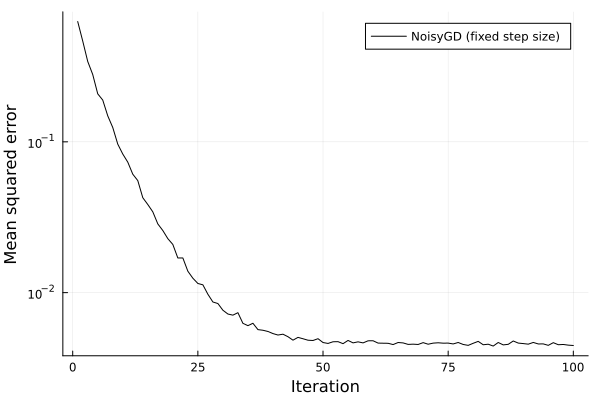

In [4]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*(A'*(A*x - y) + std*randn(n,K))
    end
    return return x
end

function comp_mse(max_itr) 
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="NoisyGD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [5]:
function DU_GD(max_itr, y, η)
    x = zeros(n, K)
    for i in 0:max_itr-1
        x = x - η[i+1]*(A'*(A*x - y) + std*randn(n,K))
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [6]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [7]:
function train(opt, η)
    ps = Flux.params(η) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do
                x̂ = DU_GD(itr, y, η)
                loss(x_opt, x̂)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_opt = mini_batch(K)
        x̂ = DU_GD(itr, y, η)
        println(itr, " ", loss(x_opt, x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [8]:
function comp_mse_DUGD(max_itr, η)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

1 1.028139104149536
2 0.9768640905218099
3 0.9164546290421282
4 0.7972716100187442
5 0.7480059635149015
6 0.6091804814402502
7 0.5821223811688915
8 0.5078307206160648
9 0.46353291349943165
10 0.382525641442715
11 0.35436369168878606
12 0.2845453712055921
13 0.2575216857639584
14 0.2434073201626107
15 0.2078393537700341
16 0.17991482420424632
17 0.1596486173407366
18 0.14256552739154846
19 0.13202282884403482
20 0.10327796805807347
21 0.09267956525756497
22 0.0789882876397039
23 0.07446462724581454
24 0.06664616643324764
25 0.05680064198346649
26 0.04876990118667765
27 0.04019796416888556
28 0.04033110863897421
29 0.034285007175176546
30 0.028735188040402444
31 0.02544560591356539
32 0.023675371382452487
33 0.01903858938507805
34 0.017071912153812267
35 0.01623172222934912
36 0.013929371964215342
37 0.013721444648919258
38 0.011102026817664605
39 0.010524741000143296
40 0.009579105370692951
41 0.008369698210110667
42 0.007214265643214982
43 0.006545645872109551
44 0.006338131225165919
4

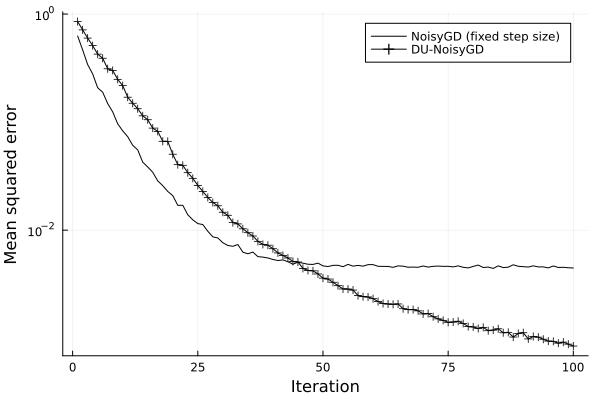

In [9]:
η_train = zeros(num_itr) 
opt = ADAM(adam_lr) 
train(opt, η_train)
DUGD_mse =[comp_mse_DUGD(i, η_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-NoisyGD", color=:black, marker=:+, yscale=:log10)

In [10]:
savefig("DU-NoisyGD.pdf")

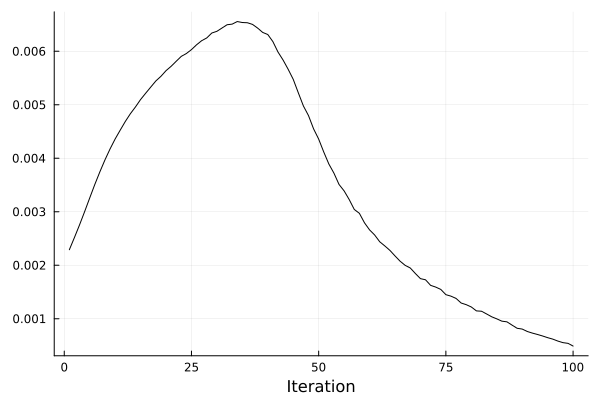

In [11]:
plot(1:num_itr, η_train, color=:black, xlabel="Iteration", legend=false)

In [12]:
savefig("DU-NisyGD-param.pdf")